# Import libraries

In [26]:
import numpy as np
import scipy as sp
import scipy.stats
import scipy.io as SPO
from matplotlib import pyplot as plt
import pandas as pd
from numpy.linalg import inv
from scipy.signal import find_peaks

# Load training data

In [18]:
# Training data
# Functional activation over time
B = SPO.loadmat('../data/RS_Imaging/Data1.mat');
C = SPO.loadmat('../data/RS_Imaging/Data2.mat');

Data1 = B['Data1']; # Use to select features 
Data2 = C['Data2']; # Use as test data

In [50]:
# Labels
# Structural connectivity for GSP approach
A = SPO.loadmat('../data/Structural_Data/A_Glasser.mat');
Adj = A['A_Glasser'];

# Behavioral variables
D = SPO.loadmat('../data/Behavioral_Data/Fluid.mat');
E = SPO.loadmat('../data/Behavioral_Data/Crystal.mat');
F = SPO.loadmat('../data/Behavioral_Data/Total.mat');
G = SPO.loadmat('../data/Behavioral_Data/BEHAV_SCORES.mat')

Fluid = D['Fluid'];
Crystal = E['Crystal'];
Total = F['Total'];
BEHAV_SCORES = G['BEHAV_SCORES']; # PCA reduced measures of intelligence

In [51]:
# Print sizes of input data
print(Data1.shape) # region, timeseries, person
print(Data2.shape) # region, timeseries, person
print(Adj.shape)
print(Fluid.shape) # person, iq measure
print(Crystal.shape) # person, iq measure
print(Total.shape) # person, iq measure
print(BEHAV_SCORES.shape) # person, iq measure

(360, 2380, 100)
(360, 2380, 100)
(360, 360)
(100, 15)
(100, 4)
(100, 8)
(100, 2)


# Plot a singal for demonstration

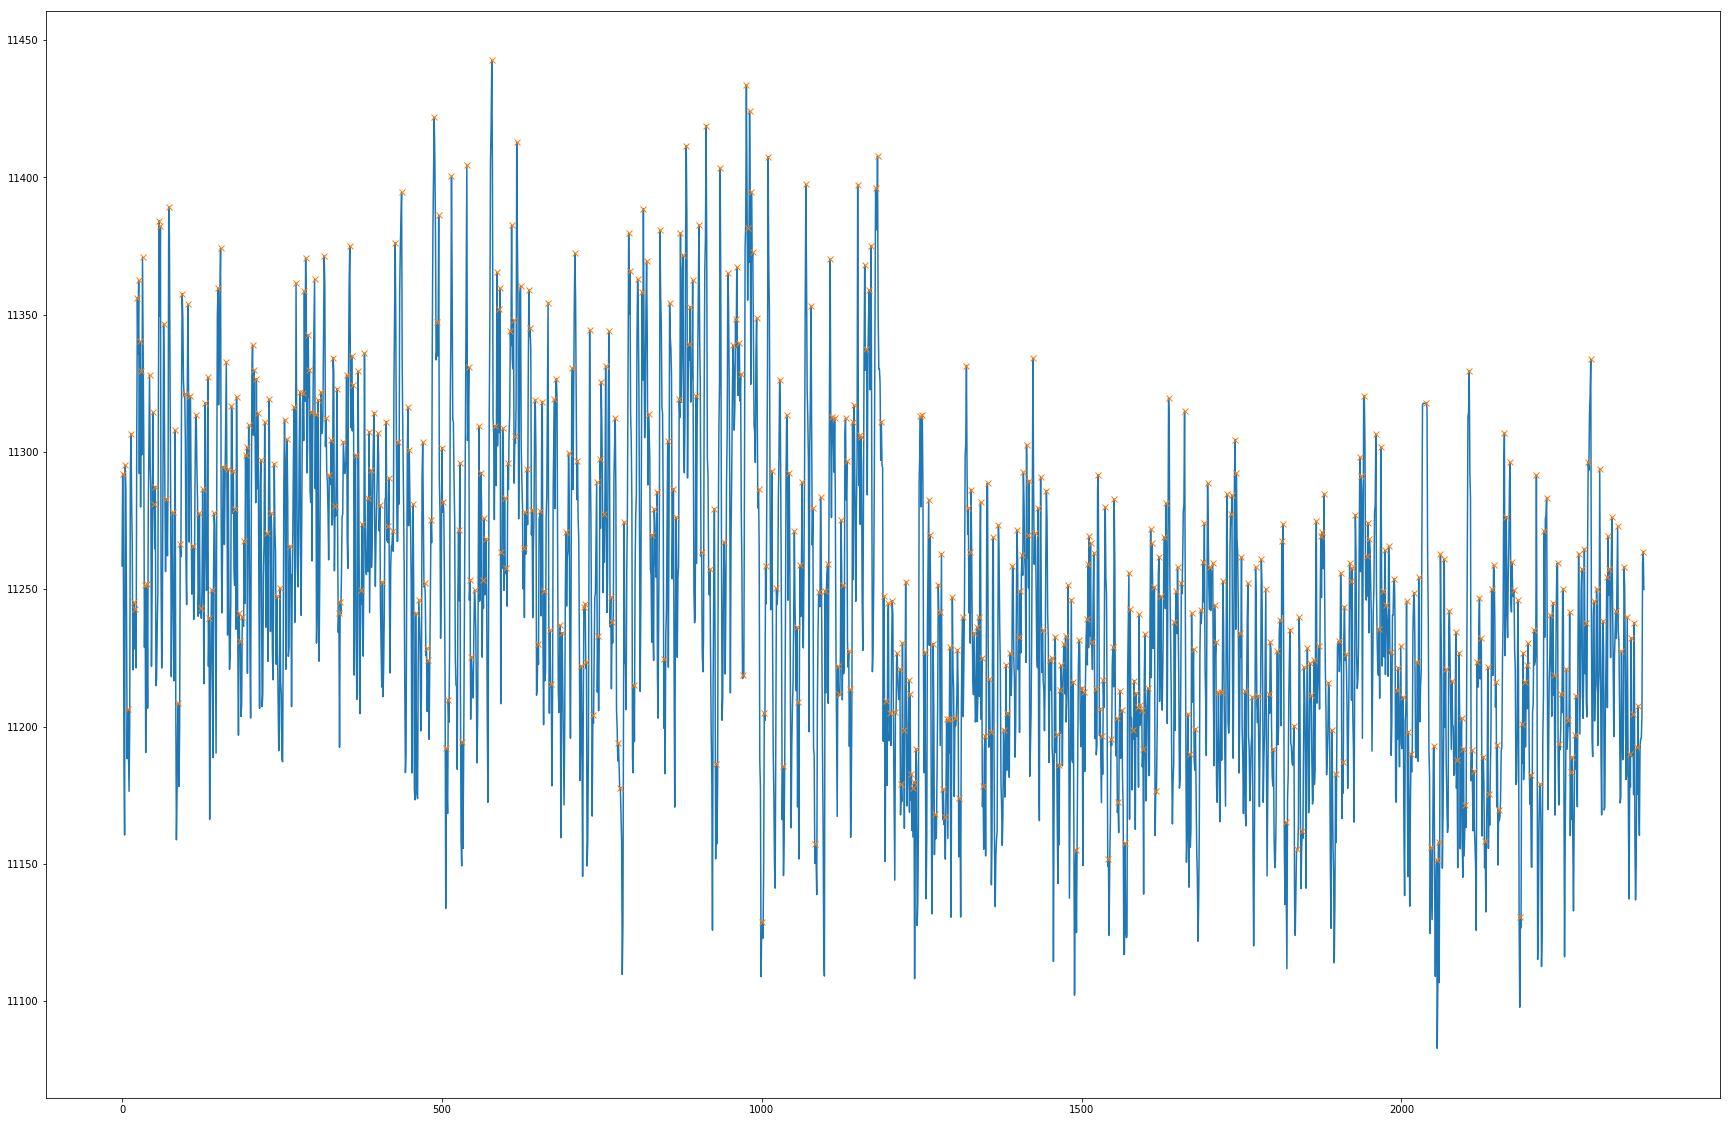

In [41]:
signal = Data1[0,:,0]
peaks, _ = find_peaks(signal, height=0)
plt.figure(figsize=(30,20))
plt.plot(signal)
plt.plot(peaks, signal[peaks], "x")
plt.show()

# Extract wave features

In [43]:
nRegions = Data1.shape[0]
nTimepoints = Data1.shape[1]
nPeople = Data1.shape[2]

# This will hold all the extracted features for all 100 people and 360 brain regions
AllData = []

# for every new sample
for i in range(nPeople):
    # for every brain region, we create 9 wave-based features
    newperson = []
    for j in range(nRegions):
        signal = Data1[j,:,i]

        # Extract features
        features = {}
        rpeaks, _ = find_peaks(signal, height=0)

        # 'mean_peak_height'
        peakheights = [signal[rpeaks[i]] for i in range(len(rpeaks))]
        mean_peak_height = np.mean(peakheights)
        features['mean_peak_height'] = mean_peak_height
        # 'mean_signal'
        mean_signal = np.mean(signal)
        features['mean_signal'] = mean_signal
        # 'mean_peak_distance'
        peakdistances = [(rpeaks[i + 1] - rpeaks[i]) for i in range(len(rpeaks) - 1)]
        mean_peak_distance = np.mean(peakdistances)
        features['mean_peak_distance'] = mean_peak_distance
        # 'mean_number_ofpeaks'
        mean_number_ofpeaks = len(rpeaks)
        features['mean_number_ofpeaks'] = mean_number_ofpeaks
        # 'stdev_peak_height'
        peakheights = [signal[rpeaks[i]] for i in range(len(rpeaks))]
        stdev_peak_height = np.std(peakheights, ddof=1)
        features['stdev_peak_height'] = stdev_peak_height
        # 'stdev_signal'
        stdev_signal = np.std(signal, ddof=1)
        features['stdev_signal'] = stdev_signal
        # 'stdev_peak_distance'
        peakdistances = [(rpeaks[i + 1] - rpeaks[i]) for i in range(len(rpeaks) - 1)]
        stdev_peak_distance = np.std(peakdistances, ddof=1)
        features['stdev_peak_distance'] = stdev_peak_distance
        # 'min'
        features['min'] = np.min(signal)
        # 'max'
        features['max'] = np.min(signal)

        entry = [x for x in features.values()]
        newperson = newperson + entry # todo: this is very slow, use pandas
    AllData.append(newperson)

# Save to csv

In [45]:
# Save to a csv
AllData = np.nan_to_num(AllData)
import csv
with open('waveFeatures.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(AllData)